In [25]:
from IPython.display import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import matplotlib.image as mpimg
import yaml
import open3d
%matplotlib inline

In [26]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:,:3]

In [27]:
def print_projection_plt(points, color, image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),3, (int(color[i]),255,255),-1)
    cv2.imwrite('./result/img_proj.png',cv2.cvtColor(hsv_image,cv2.COLOR_HSV2BGR))
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

In [28]:
def depth_color(val, min_d=0, max_d=120):
    np.clip(val, 0, max_d, out=val) 
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8) 
def points_filter(points,img_width,img_height,P,RT):
    ctl = RT
    ctl = np.array(ctl)
    dim_norm = 3
    dim_proj = ctl.shape[1]
    print(dim_norm,dim_proj)
    fov_x = 2*np.arctan2(img_width, 2*P[0,0])*180/3.1415926+10
    fov_y = 2*np.arctan2(img_height, 2*P[1,1])*180/3.1415926+10
    R= np.eye(4)
    p_l = np.ones((points.shape[0],points.shape[1]+1))
    p_l[:,:3] = points
    p_c = np.matmul(ctl,p_l.T)
    p_c = p_c.T
    x = p_c[:,0]
    y = p_c[:,1]
    z = p_c[:,2]

    #dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    xangle = np.arctan2(x, z)*180/np.pi;
    yangle = np.arctan2(y, z)*180/np.pi;
    flag2 = (xangle > -fov_x/2) & (xangle < fov_x/2)
    flag3 = (yangle > -fov_y/2) & (yangle < fov_y/2)
    res = p_l[flag2&flag3,:3]
    res = np.array(res)
    x = res[:, 0]
    y = res[:, 1]
    z = res[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    color = depth_color(dist, 0, 70)
#     temp = np.reshape(p_c[:,dim_norm-1], (-1,1))
#     poin = p_c[:,:dim_norm]/(np.matmul(temp, np.ones([1,dim_norm])))
    return res,color

In [29]:
def get_cam_mtx(filepath):
    data = np.loadtxt(filepath)
    P = np.zeros((3,3))
    P[0,0] = data[0]
    P[1,1] = data[1]
    P[2,2] = 1
    P[0,2] = data[2]
    P[1,2] = data[3]
    return P

In [30]:
def generate_colorpc(img, pc, pcimg, debug=False):
    """
    Generate the PointCloud with color
    Parameters:
        img: image
        pc: PointCloud
        pcimg: PointCloud project to image
    Return:
        pc_color: PointCloud with color e.g. X Y Z R G B
    """
    x = np.reshape(np.int32(pcimg[0]), (-1,1))
    y = np.reshape(np.int32(pcimg[1]), (-1,1))
    xy = np.hstack([x,y])

    pc_color = []
    for idx, i in enumerate(xy):
        if (i[0]>1 and i[0]<img.shape[1]) and (i[1]>1 and i[1]<img.shape[0]): 
            bgr = img[int(i[1]), int(i[0])]
            p_color = [pc[idx][0], pc[idx][1], pc[idx][2], bgr[2], bgr[1], bgr[0]]
            pc_color.append(p_color)
    pc_color = np.array(pc_color)

    return pc_color

In [31]:
def save_pcd(filename, pc_color):
    """
    Save the PointCloud with color in the term of .pcd
    Parameter:
        filename: filename of the pcd file
        pc_color: PointCloud with color
    """
    f = open(filename, "w")

    f.write("# .PCD v0.7 - Point Cloud Data file format\n")
    f.write("VERSION 0.7\n")
    f.write("FIELDS x y z rgb\n")
    f.write("SIZE 4 4 4 4\n")
    f.write("TYPE F F F F\n")
    f.write("COUNT 1 1 1 1\n")
    f.write("WIDTH {}\n".format(pc_color.shape[0]))
    f.write("HEIGHT 1\n")
    f.write("POINTS {}\n".format(pc_color.shape[0]))
    f.write("DATA ascii\n")

    for i in pc_color:
        # rgb = (int(i[3])<<16) | (int(i[4])<<8) | (int(i[5]) | 1<<24)
        # f.write("{:.6f} {:.6f} {:.6f} {}\n".format(i[0],i[1],i[2],rgb))
        f.write("{:.6f} {:.6f} {:.6f} {} {} {}\n".format(i[0],i[1],i[2],i[3],i[4],i[5]))
    
    f.close()

In [32]:
def draw_pc(pc_xyzrgb):
    """
    Plot pointcloud with color
    Parameter:
        pc_xyzrgb: [[x, y, z, r, g, b],...]
    """
    pc = open3d.geometry.PointCloud()
    pc.points = open3d.utility.Vector3dVector(pc_xyzrgb[:, 0:3])
    if pc_xyzrgb.shape[1] == 3:
        open3d.visualization.draw_geometries([pc])
        return 0
    if np.max(pc_xyzrgb[:, 3:6]) > 20:  ## 0-255
        pc.colors = open3d.utility.Vector3dVector(pc_xyzrgb[:, 3:6] / 255.)
    else:
        pc.colors = open3d.utility.Vector3dVector(pc_xyzrgb[:, 3:6])
    open3d.visualization.draw_geometries([pc])
    return 0

In [33]:
def read_pcd(path):
    """
    Read pcd file generated by ./func.py/save_pc
    Parameter:
        path: path of pcd file
    Return:
        xyzrgb: numpy array of colored pointcloud [[x, y, z. r, g, b], ...]
    """
    xyzrgb = []
    with open(path, 'r') as f:
        content = f.readlines()
        for i in content[10:]:
            i_content = i.split(" ")
            x, y, z = float(i_content[0]), float(i_content[1]), float(i_content[2])
            r, g, b = float(i_content[3]), float(i_content[4]), float(i_content[5][:-1])

            xyzrgb.append([x,y,z,r,g,b])

    return np.array(xyzrgb)

In [34]:
def get_lidar2cam_mtx(filepath):
    with open(filepath,'r') as f:
        data = yaml.load(f,Loader= yaml.Loader)
    q = data['os1_cloud_node-pylon_camera_node']['q']
    q = np.array([q['x'],q['y'],q['z'],q['w']])
    t = data['os1_cloud_node-pylon_camera_node']['t']
    t = np.array([t['x'],t['y'],t['z']])
    R_vc = Rotation.from_quat(q)
    R_vc = R_vc.as_matrix()

    RT = np.eye(4,4)#returns identity matrix 
    RT[:3,:3] = R_vc
    RT[:3,-1] = t
    RT = np.linalg.inv(RT)# as we are doing lidar to image we need to take the inverse.
    
    return RT

In [35]:
image = cv2.imread('./data/res.png')
points = load_from_bin('./data/000000.bin')
img_height, img_width, channels = image.shape
distCoeff = np.array([-0.134313,-0.025905,0.002181,0.00084,0])
distCoeff = distCoeff.reshape((5,1))
P = get_cam_mtx('./data/camera_info.txt')

3 4


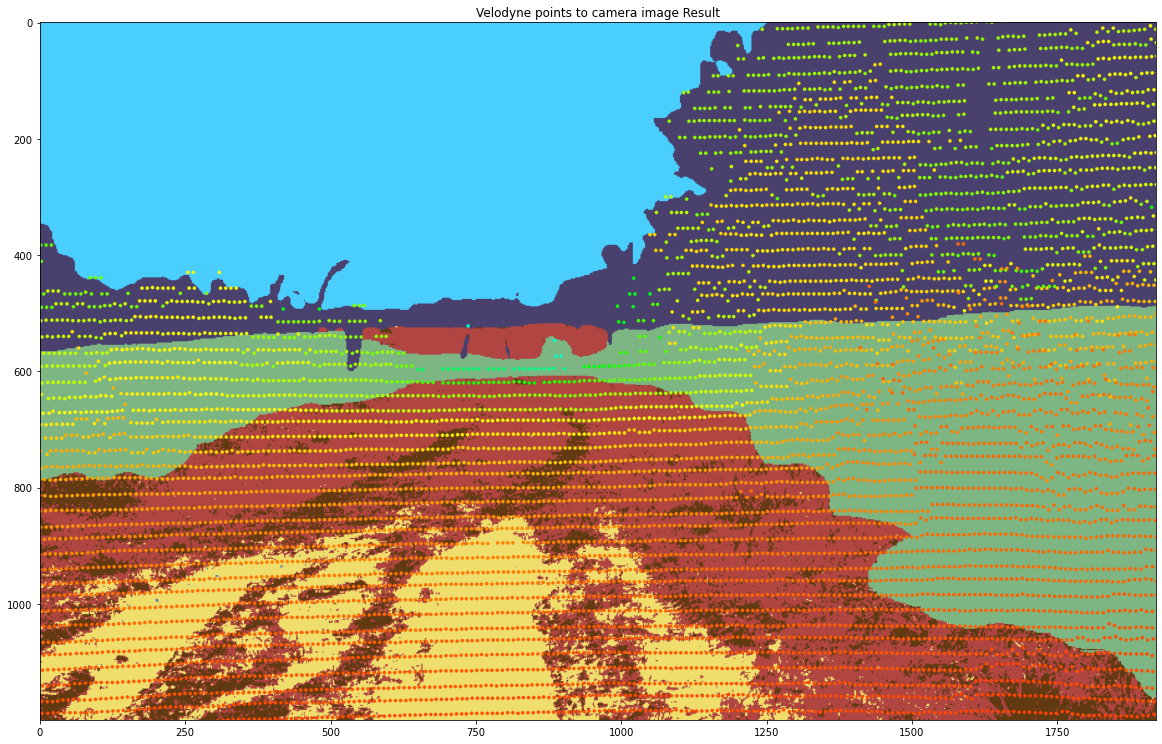

In [36]:
RT= get_lidar2cam_mtx('./data/LC_calib0.yaml')
R_vc = RT[:3,:3]
T_vc = RT[:3,3]
T_vc = T_vc.reshape(3, 1)
rvec,_ = cv2.Rodrigues(R_vc)
tvec = T_vc
xyz_v, c_ = points_filter(points,img_width,img_height,P,RT)

imgpoints, _ = cv2.projectPoints(xyz_v[:,:],rvec, tvec, P, distCoeff)
lidrpts, _ = cv2.projectPoints(np.array(points),rvec, tvec, P, distCoeff)
imgpoints = np.squeeze(imgpoints,1)
imgpoints = imgpoints.T
lidrpts = np.squeeze(lidrpts,1)
res = print_projection_plt(points=imgpoints, color=c_, image=image)
pc_color = generate_colorpc(image,xyz_v[:,:],imgpoints)
save_pcd('./result/lol.pcd',pc_color)
draw_pc(pc_color)
plt.subplots(1,1, figsize = (20,20) )
plt.title("Velodyne points to camera image Result")
plt.imshow(res)